Importing libraries


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

Mounting G-Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Reading Dataset using Pandas

In [4]:
train=pd.read_csv("/content/drive/My Drive/metro-bike-share-trip-data.csv")
print(train)

         Trip ID  Duration  ... Precinct Boundaries Census Tracts
0       18222186     15060  ...                 NaN           NaN
1        9518671     77160  ...                 NaN           NaN
2       20444932     86400  ...                 NaN           NaN
3       20905031     18840  ...                 NaN           NaN
4       21031476     86400  ...                 NaN           NaN
...          ...       ...  ...                 ...           ...
132422   4907293      2520  ...               847.0         567.0
132423   4908300      1080  ...               660.0         694.0
132424   4726795      1500  ...               660.0         694.0
132425   5034026       780  ...               527.0         542.0
132426   5250466       300  ...              1262.0         544.0

[132427 rows x 18 columns]


Type and Count of Pass Types

In [5]:
train['Passholder Type'].value_counts()

Monthly Pass    81300
Walk-up         41232
Flex Pass        9513
Staff Annual      382
Name: Passholder Type, dtype: int64

Visualizing Missing Data

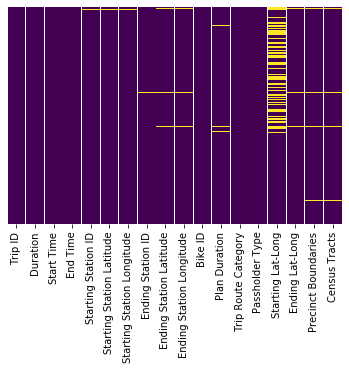

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Missing data percent

In [7]:
print("Missing data percentage as per individual columns:")
train_na = (train.isnull().sum()*100)/len(train)
train_na

Missing data percentage as per individual columns:


Trip ID                        0.000000
Duration                       0.000000
Start Time                     0.000000
End Time                       0.000000
Starting Station ID            0.014348
Starting Station Latitude      0.036246
Starting Station Longitude     0.036246
Ending Station ID              0.072493
Ending Station Latitude        0.793645
Ending Station Longitude       0.793645
Bike ID                        0.007551
Plan Duration                  0.578432
Trip Route Category            0.000000
Passholder Type                0.000000
Starting Lat-Long             25.527272
Ending Lat-Long                0.793645
Precinct Boundaries            0.829891
Census Tracts                  0.829891
dtype: float64

Dropping Null Values from Dataset


In [0]:
train = train.dropna()

No. of Rows left after Data Cleaning


In [9]:
train.shape[0]

97777

PassType Vs Duration (ScatterPlot)

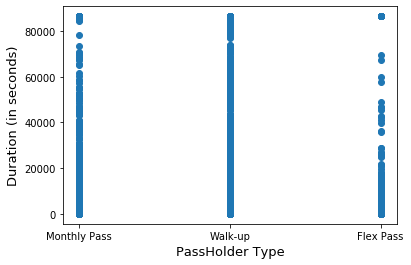

In [10]:
fig, ax = plt.subplots()
ax.scatter(train['Passholder Type'], train['Duration'])
plt.ylabel('Duration (in seconds)', fontsize=13)
plt.xlabel('PassHolder Type', fontsize=13)
plt.show()

Distance Calculation

In [0]:
l = []
import math 
degrees_to_radians = math.pi/180.0
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    
    a = ((math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2)) +(math.cos(phi1)*math.cos(phi2)))
    if a>1:
        a=0.999999
    dis = math.acos( a )
    return dis*6373
for i in range(97777):
    l.append(distance_on_unit_sphere(train['Starting Station Latitude'].iloc[i],
                                     train['Starting Station Longitude'].iloc[i],
                                     train['Ending Station Latitude'].iloc[i],
                                     train['Ending Station Longitude'].iloc[i]))

Temporary Dataframe 


In [0]:
temp = pd.DataFrame(data=[train['Duration'],
                               train['Starting Station Latitude'],
                               train['Starting Station Longitude'],
                               train['Ending Station Latitude'],
                               train['Ending Station Longitude'],
                               train['Plan Duration']],
                               index=['Duration',
                                      'Starting Station Latitude',
                                      'Starting Station Longitude',
                                      'Ending Station Latitude',
                                      'Ending Station Longitude',
                                      'Plan Duration'])

New Training Dataset

In [13]:
distance = pd.DataFrame({'Distance':l})
new_train = temp.T
print("Shape of new train ",new_train.shape)
print ("Shape of distance ",distance.shape)
distance.tail()

Shape of new train  (97777, 6)
Shape of distance  (97777, 1)


,Distance
97772,0.000134
97773,2.698472
97774,3.958028
97775,1.840795
97776,0.680439


In [14]:
new_train.tail()

,Duration,Starting Station Latitude,Starting Station Longitude,Ending Station Latitude,Ending Station Longitude,Plan Duration
132422,2520.0,34.051102,-118.26456,34.051102,-118.26456,0.0
132423,1080.0,34.049980,-118.24716,34.035679,-118.27081,30.0
132424,1500.0,34.056610,-118.23721,34.031052,-118.26709,30.0
132425,780.0,34.039188,-118.23253,34.044159,-118.25158,365.0
132426,300.0,34.053021,-118.24795,34.056969,-118.25359,30.0


In [15]:
new_train = new_train.reset_index(drop=True)
new_train = pd.concat([distance,
                       new_train,
                       pd.get_dummies(data=train['Passholder Type']).reset_index(),
                       pd.get_dummies(data=train['Trip Route Category'],drop_first=True).reset_index()],
                       axis=1)
new_train = new_train.drop('index',axis=1)
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97777 entries, 0 to 97776
Data columns (total 11 columns):
Distance                      97777 non-null float64
Duration                      97777 non-null float64
Starting Station Latitude     97777 non-null float64
Starting Station Longitude    97777 non-null float64
Ending Station Latitude       97777 non-null float64
Ending Station Longitude      97777 non-null float64
Plan Duration                 97777 non-null float64
Flex Pass                     97777 non-null uint8
Monthly Pass                  97777 non-null uint8
Walk-up                       97777 non-null uint8
Round Trip                    97777 non-null uint8
dtypes: float64(7), uint8(4)
memory usage: 5.6 MB


In [30]:
print("There are 3 different types of Passholder : ")
train['Passholder Type'].value_counts()

There are 3 different types of Passholder : 


Monthly Pass    60051
Walk-up         30531
Flex Pass        7195
Name: Passholder Type, dtype: int64

SVM Prediction for Walk-Up Pass


In [28]:
X1 = new_train.drop('Walk-up',axis=1)
y1 = new_train['Walk-up']
X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.33)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
print(clf.predict(X_test))
from sklearn.metrics import accuracy_score
print ('Accuracy Score :',accuracy_score(y_test, clf.predict(X_test)))

[1 1 0 ... 1 0 1]
Accuracy Score : 0.9967459013853163


SVM Prediction for Monthly Pass


In [25]:
X2 = new_train.drop('Monthly Pass',axis=1)
y2 = new_train['Monthly Pass']
X_train,X_test,y_train,y_test = train_test_split(X2,y2,test_size=0.33,shuffle=False)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
print(clf.predict(X_test))
from sklearn.metrics import accuracy_score
print ('Accuracy Score :',accuracy_score(y_test, clf.predict(X_test)))

[0 1 1 ... 1 0 1]
Accuracy Score : 0.9966839185545604


SVM Prediction for Flex Pass


In [26]:
X3 = new_train.drop('Flex Pass',axis=1)
y3 = new_train['Flex Pass']
X_train,X_test,y_train,y_test = train_test_split(X3,y3,test_size=0.33)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
print(clf.predict(X_test))
from sklearn.metrics import accuracy_score
print ('Accuracy Score :',accuracy_score(y_test, clf.predict(X_test)))

[1 0 0 ... 0 0 0]
Accuracy Score : 0.9990702575386617
